# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 11 </span>
## <span style="color:orange"> Keras - Neural Network regression </span>

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
plt.rcParams.update({
    'font.family':'cmr10',
    'mathtext.fontset': 'cm',
    'axes.formatter.use_mathtext': True,
    'axes.axisbelow': True,
    'figure.figsize': [6.0, 6.0],
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size':15,
})

# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

### Overview 

In this notebook our task will be to perform machine learning regression on noisy data with a Neural Network (NN).

We will explore how the ability to fit depends on the structure of the NN. The goal is also to build intuition about why prediction is difficult.

### The Prediction Problem

Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make predictions, we will consider a NN that depends on its parameters, weights and biases. The functions that the NN can model respresent the **model class** that we are using to try to model the data and make predictions.

To learn the parameters of the NN, we will train our models on a **training data set** and then test the effectiveness of the NN on a *different* dataset, the **validation data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen.

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

We will try to get a qualitative picture by examining plots on validation and training data.

### Linear fit

Consideriamo la funzione lineare:
$$
f(x)=2x+1
$$

In [79]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

In [80]:
N_train = [500, 1000, 1500]
N_epochs = [10, 30, 40, 50, 100]
sigma = [0.05, 0.1, 0.2, 0.25]

Definiamo le seguenti funzioni:
- __initialize_traing__ : genera le coppie di dati input che hanno un certo errore $(\sigma)$ rispetto al comportamento ideale della retta
- __initialize_validation__ : gerera le coppie di dati per la valdazione del modello
- __neurons__ : inizializza il modello con con certo numero $(n_{neurons})$ di neuroni
- __history__ : gli diamo in input le coppie di training $(x_{train}, y_{train})$ da cui l'ottimizzatore troverà i pesi migliori per minimizzare la funzione costo (_Mean Square Error_).


In [81]:
def initialize_training(n_train, sigma, m, b):
    # generate training inputs
    np.random.seed(0)
    x_train = np.random.uniform(-1, 1, 500)
    sigma = 0.1 # noise standard deviation, for the moment it is absent
    y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
    return x_train, y_train

def initialize_validation(m, b, sigma):
    x_valid = np.random.uniform(-1, 1, 50)
    x_valid.sort()
    y_valid = np.random.normal(m * x_valid + b, sigma)
    return x_valid, y_valid

def neurons(n_neurons):
    model = tf.keras.Sequential()
    model.add(Dense(n_neurons, input_shape=(1,)))
    # compile the model choosing optimizer, loss and metrics objects
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    # get a summary of our composed model
    model.summary()
    return model

def history(model, n_epoch, x_train, y_train, x_valid, y_valid):
    history = model.fit(x=x_train, y=y_train, 
              batch_size=32, epochs=n_epoch,
              shuffle=True, # a good idea is to shuffle input before at each epoch
              validation_data=(x_valid, y_valid))
    return history


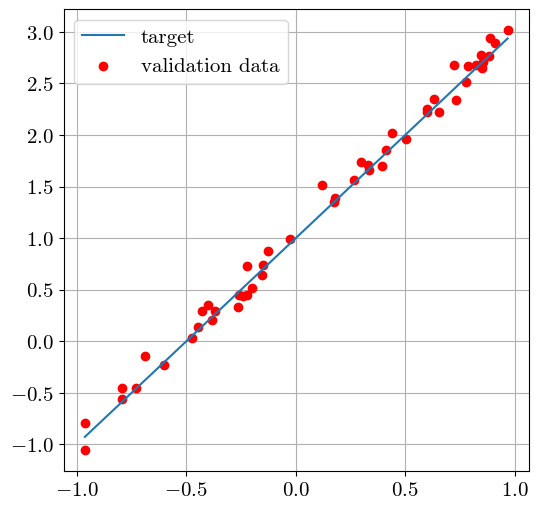

In [82]:
# plot validation and target dataset

x_train, y_train = initialize_training(500, 0.1, m, b)
x_valid, y_valid = initialize_validation(m,b,0.1)

y_target = m * x_valid + b # ideal (target) linear function
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

In questo caso abbiamo solo due parametri da trovare $(m,b)$ quindi ci basta un solo neurone.

In [88]:
model = neurons(1)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Guardando i pesi possiamo vedere se il modello è stato allenanto bene: $w_1$ rappresenta il coefficiente angolare della retta e $b$ l'intercetta. Quindi in questo caso ci aspettiamo: $w_1=2$ e $b=1$

In [89]:
history = history(model, 30, x_train, y_train, x_valid, y_valid)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2962 - mse: 4.2962 - val_loss: 4.3255 - val_mse: 4.3255
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3518 - mse: 3.3518 - val_loss: 3.2482 - val_mse: 3.2482
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5796 - mse: 2.5796 - val_loss: 2.4905 - val_mse: 2.4905
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9933 - mse: 1.9933 - val_loss: 1.9345 - val_mse: 1.9345
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5397 - mse: 1.5397 - val_loss: 1.5143 - val_mse: 1.5143
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2742 - mse: 1.2742 - val_loss: 1.1967 - val_mse: 1.1967
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9325 - mse: 0.9325 - val_loss: 0.9495 - val_mse: 0.9495
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8155 - mse: 0.8155 - val_loss: 0.7576 - val_mse: 0.7576
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6146 - mse:

In [ ]:
# return weights and biases
model.get_weights()

[array([[1.9949011]], dtype=float32), array([0.9891711], dtype=float32)]

In [90]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# evaluate model with the exact curve
score_target = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score_target[0])
print('Test accuracy:', score_target[1])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0127 - mse: 0.0127

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0166 - mse: 0.0166

Test loss: 0.01860014535486698
Test accuracy: 0.01860014535486698
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0049 - mse: 0.0049

Test loss: 0.005964608862996101
Test accuracy: 0.005964608862996101


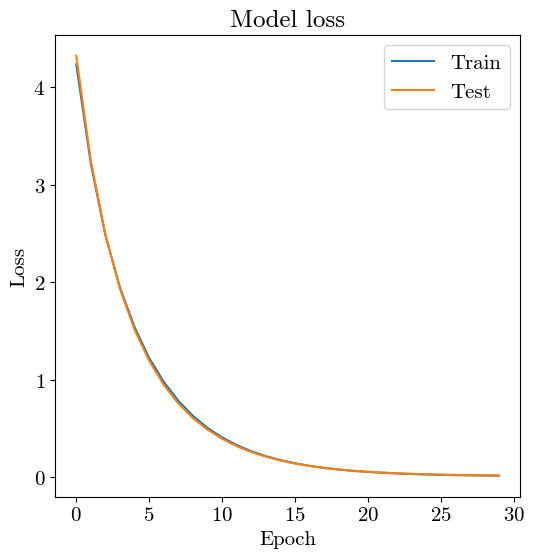

In [91]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x702f14318310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


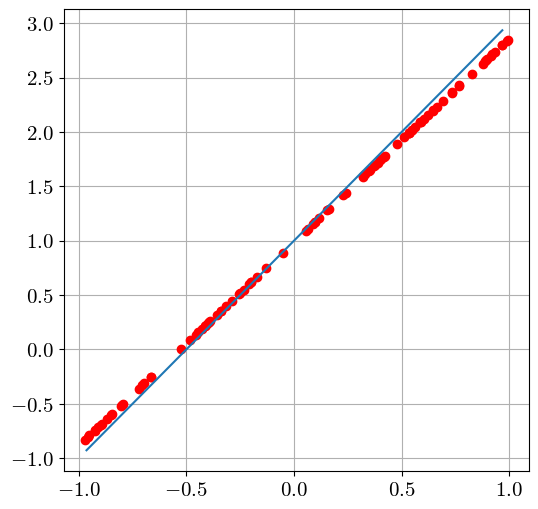

In [92]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

### Exercise 11.1

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

In [ ]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted_40 = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

con il train modifico i parmateri, con il valid calcolo la loss per capire se i parametri che ho trovato nel train sono giusti

### Exercise 11.2

Try to extend the model to obtain a reasonable fit of the following polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

Find good (& reasonable) choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Check your NN model by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

In [ ]:
# target parameters of f(x) = ax^3 +b x^2 +c x +d
a = 3 
b = -2
c = - 3
d = 4

In [ ]:
import numpy as np

# generate training inputs
np.random.seed(0)
x_train_pol = np.random.uniform(-1, 1, 500)
x_valid_pol = np.random.uniform(-1, 1, 50)
x_valid_pol.sort()
y_target_pol = d + c* x_valid_pol +b * x_valid_pol**2 + a * x_valid_pol**3  # ideal (target) linear function

sigma = 0.1 # noise standard deviation, for the moment it is absent
y_train_pol = np.random.normal(d + c* x_train_pol+b * x_train_pol**2 + a * x_train_pol**3 , sigma) # actual measures from which we want to guess regression parameters
y_valid_pol = np.random.normal(d + c* x_valid_pol +b * x_valid_pol**2 + a * x_valid_pol**3 , sigma)

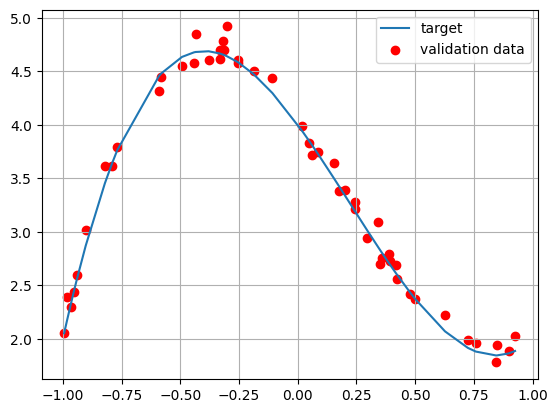

In [ ]:
# plot validation and target dataset

import matplotlib.pyplot as plt
plt.plot(x_valid_pol, y_target_pol, label='target')
plt.scatter(x_valid_pol, y_valid_pol, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(4, input_shape=(1,), activation='relu'))
model.add(Dense(16, input_shape=(1,), activation='relu'))
model.add(Dense(16, input_shape=(1,), activation='relu'))
model.add(Dense(4, input_shape=(1,), activation='relu'))
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

/home/catezac/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# get a summary of our composed model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
history = model.fit(x=x_train_pol, y=y_train_pol, 
          batch_size=40, epochs=60,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid_pol, y_valid_pol))

Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.8437 - mse: 10.8437 - val_loss: 7.6716 - val_mse: 7.6716
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7405 - mse: 6.7405 - val_loss: 4.9457 - val_mse: 4.9457
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5683 - mse: 4.5683 - val_loss: 3.3421 - val_mse: 3.3421
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0736 - mse: 3.0736 - val_loss: 2.3831 - val_mse: 2.3831
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3410 - mse: 2.3410 - val_loss: 1.8146 - val_mse: 1.8146
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8520 - mse: 1.8520 - val_loss: 1.4811 - val_mse: 1.4811
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4841 - mse: 1.4841 - val_loss: 1.2793 - val_mse: 1.2793
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3673 - mse: 1.3673 - val_loss: 1.1569 - val_mse: 1.1569
Epoch 9/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2430 - ms

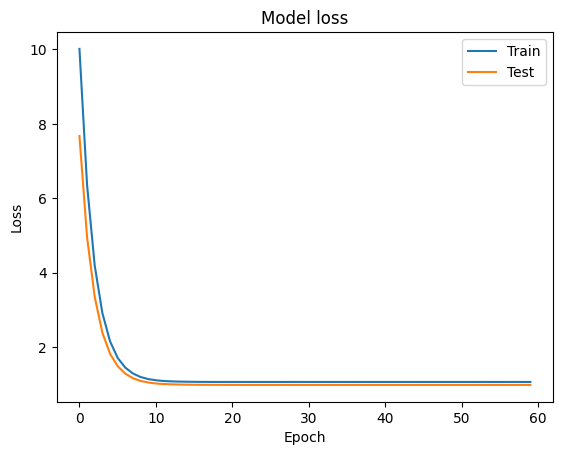

In [ ]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


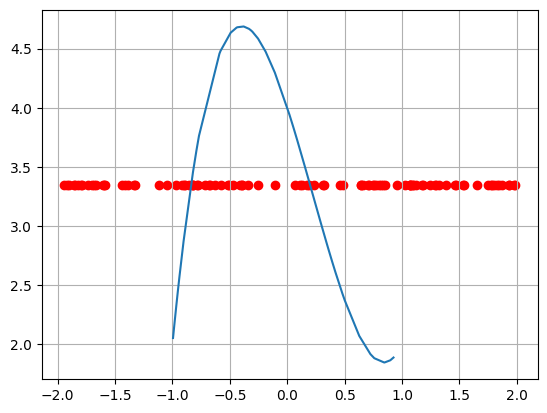

In [ ]:
x_predicted_pol = np.random.uniform(-2, 2, 100)
y_predicted_pol = model.predict(x_predicted_pol)
plt.scatter(x_predicted_pol, y_predicted_pol,color='r')
plt.plot(x_valid_pol, y_target_pol)
plt.grid(True)
plt.show()

### Exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

Ideas to meditate on these exercises and judge your results can be found <a href=https://xkcd.com/2048/>here</a>

In [ ]:
import numpy as np

# generate training inputs
np.random.seed(0)
x_train_3 = np.random.uniform(-3/2, 3/2, 150)
y_train_3 = np.random.uniform(-3/2, 3/2, 150)
x_valid_3 = np.random.uniform(-3/2, 3/2, 50)
y_valid_3 = np.random.uniform(-3/2, 3/2, 50)
x_valid_3.sort()
y_valid_3.sort()

X_valid_3, Y_valid_3 = np.meshgrid(x_valid_3, y_valid_3)
X_train_3, Y_train_3 = np.meshgrid(x_train_3, y_train_3)



print(X_valid_3.shape)
print(Y_valid_3.shape)

z_target_3 = np.sin(X_valid_3**2+Y_valid_3**2)  # ideal (target)  function

sigma = 0.1 # noise standard deviation, for the moment it is absent
z_train_3 = np.random.normal(np.sin(X_train_3**2+Y_train_3**2) , sigma) # actual measures from which we want to guess regression parameters
z_valid_3 = np.random.normal(np.sin(X_valid_3**2+Y_valid_3**2) , sigma)
print(z_valid_3.shape)

(50, 50)
(50, 50)
(50, 50)


/tmp/ipykernel_120998/1450241792.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 640x480 with 0 Axes>

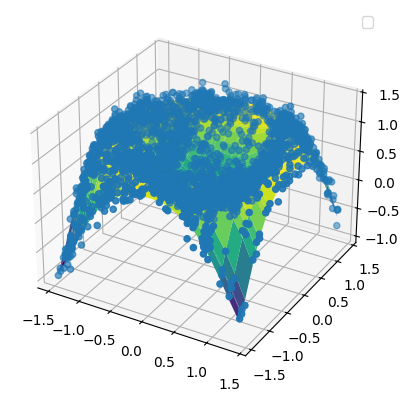

In [ ]:
# plot validation and target dataset
import matplotlib.pyplot as plt
plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_valid_3, Y_valid_3, z_valid_3)
ax.plot_surface(X_valid_3, Y_valid_3, np.sin(X_valid_3**2 + Y_valid_3**2), cmap='viridis')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model_sin = tf.keras.Sequential()
model_sin.add(Dense(4, input_shape=(2,), activation='relu'))
model_sin.add(Dense(16, activation='relu'))
model_sin.add(Dense(16, activation='relu'))
model_sin.add(Dense(4, activation='relu'))
model_sin.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model_sin.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [ ]:
# get a summary of our composed model
model_sin.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
#X_tr = np.stack((X_train_3, Y_train_3), axis = 1 ) # shape (N, 2)
X_val = np.column_stack((X_valid_3.ravel(), Y_valid_3.ravel()))  # shape (N_valid, 2)
X_train = np.column_stack((X_train_3.ravel(), Y_train_3.ravel())) 

Z_train = z_train_3.ravel()
Z_valid = z_valid_3.ravel()

history = model_sin.fit(x = X_train , y=Z_train,
          batch_size=32, epochs=50,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(X_val, Z_valid))

Epoch 1/50


704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2201 - mse: 0.2201 - val_loss: 0.1380 - val_mse: 0.1380
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1543 - mse: 0.1543 - val_loss: 0.1318 - val_mse: 0.1318
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1412 - mse: 0.1412 - val_loss: 0.1254 - val_mse: 0.1254
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1323 - mse: 0.1323 - val_loss: 0.1171 - val_mse: 0.1171
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1253 - mse: 0.1253 - val_loss: 0.1086 - val_mse: 0.1086
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1161 - mse: 0.1161 - val_loss: 0.1001 - val_mse: 0.1001
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1057 - mse: 0.1057 - val_loss: 0.0907 - val_mse: 0.0907
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0952 - mse: 0.0952 - val_loss: 0.0840 - val_mse: 0.0840
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0876 

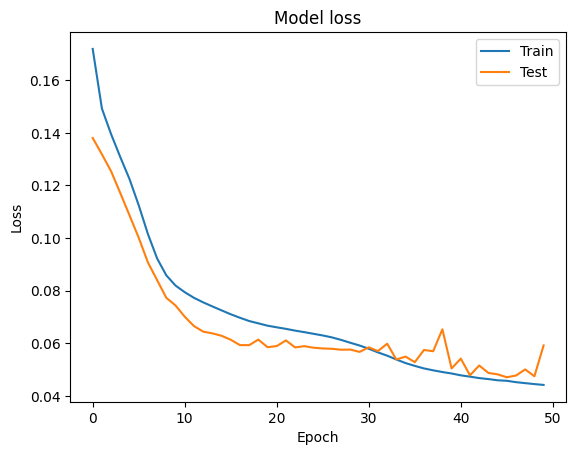

In [ ]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

  1/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
(10000, 2)
(100, 100)
(100, 100)


/tmp/ipykernel_954/3907518543.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 640x480 with 0 Axes>

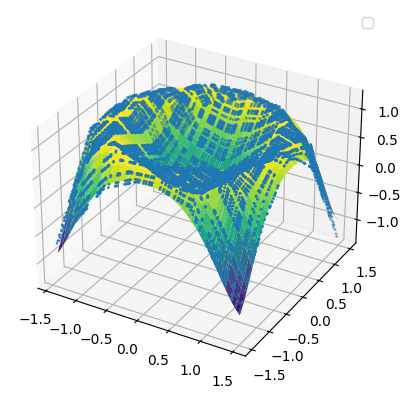

In [ ]:
x_predicted_3 = np.random.uniform(-3/2, 3/2, 100)
y_predicted_3 = np.random.uniform(-3/2,3/2, 100)

x_predicted_3.sort()
y_predicted_3.sort()

X_pred, Y_pred = np.meshgrid(x_predicted_3, y_predicted_3)

X_prediction = np.column_stack((X_pred.ravel(), Y_pred.ravel()))
Z_pred = model_sin.predict(X_prediction).reshape(X_pred.shape)

print(X_prediction.shape)
#print(X_pred)
print(Y_pred.shape)
print(Z_pred.shape)

# plot validation and target dataset
plt.figure()
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(X_pred, Y_pred, Z_pred, s=1)
Z = np.sin(X_pred**2+Y_pred**2)
ax1.plot_surface(X_pred, Y_pred, Z, cmap='viridis')
plt.legend()
plt.grid(True)
plt.show()

